In [3]:
import pandas as pd
from sklearn.model_selection import KFold
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def build_model(n, h, activation):
    '''Build neural network model'''
    
    # Number of nodes per layer
    s = []
    s.append(len(X_train[0]))

    for ii in range(0, n-2):
        s.append(h)

    s.append(num_classes)

    # Initialize empty model
    model = torch.nn.Sequential()

    # For each layer, add to existing model
    for ii, s_i in enumerate(s[:-1]): 
        
        # If activation identity, don't add any acivation
        if activation == 'identity':
            model = torch.nn.Sequential(
                model,
                torch.nn.Linear(s_i, s[ii+1])
            )
            
            continue

        # If any other activation, add the according activation
        if activation == 'relu':
            layer_activation = torch.nn.ReLU()

        if activation == 'sigmoid':
            layer_activation = torch.nn.Sigmoid()

        if activation == 'tanh':
            layer_activation = torch.nn.Tanh()

        # If it's the last layer, just add Sigmoid activation
        if ii == len(s) - 2:
            
            # Update model
            model = torch.nn.Sequential(
                model,
                torch.nn.Linear(s_i, s[ii+1]),
                torch.nn.Sigmoid()
            )
            
        else:
            
            # Update model
            model = torch.nn.Sequential(
                model,
                torch.nn.Linear(s_i, s[ii+1]),
                layer_activation
            )
    
    return(model)

In [5]:
def train_model(model, X_train, y_train, learning_rate, loss_fn):
    
    # Train neural network model
    for t in range(2001):

        # Compute outputs of model
        y_pred = model(X_train)

        # Compute loss function of model
        loss = loss_fn(y_pred, y_train)
        if t % 100 == 0:
            #print(t, loss.item())
            pass

        # Zero the gradients before running the backward pass.
        model.zero_grad()

        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model
        loss.backward()

        # Update the weights using gradient descent
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad

In [6]:
def evaluate_model(model, X_train, y_train, X_test, y_test, n, h):
    
    # Run model on training data
    y_train_pred_raw = model(X_train).tolist()
    y_train_pred = [val.index(max(val)) for val in y_train_pred_raw]

    # Run model on test data 
    y_test_pred_raw = model(X_test).tolist()
    y_test_pred = [val.index(max(val)) for val in y_test_pred_raw]
    
    # Determine accuracy on training data
    training_pred_bool = [y_train_pred[ii] == y_train[ii] for ii in range(0, len(y_train))]
    training_acc = int(sum(training_pred_bool)) / len(y_train)

    # Determine accuracy on test data
    test_pred_bool = [y_test_pred[ii] == y_test[ii] for ii in range(0, len(y_test))]
    test_acc = int(sum(test_pred_bool)) / len(y_test)

    #print('NN (n=%s, size=%s):\nTraining error: %.1f%%\nTest error: %.1f%%' % (n, h, training_error*100, test_error*100))
    
    return(test_acc)


In [16]:
def print_best_combo(dict_combo_acc):

    # Hyperparameter combination with the highest test accuracy
    best_combo = {key: value for key, value in dict_combo_acc.items() if value == max(dict_combo_acc.values())}

    n_best = list(best_combo.keys())[0].split('-')[0]
    h_best = list(best_combo.keys())[0].split('-')[1]
    learning_rate_best = list(best_combo.keys())[0].split('-')[2]
    test_acc_best = list(best_combo.values())[0]

    print('\nThe most accurate model, with %.1f%% accuracy, has %s layers, %s nodes per hidden layer, and a learning rate of %s.' % 
         (test_acc_best*100, n_best, h_best, learning_rate_best))
    

In [8]:
def plot_hyperparameter_vs_acc(dict_combo_acc):

    # Put all hyperparameter combinations and their associated accuracies is a dataframe
    n_val_combo_all = []
    h_val_combo_all = []
    learning_rate_combo_all = []

    for key, value in dict_combo_acc.items():
        n_val_combo = float(key.split('-')[0])
        h_val_combo = float(key.split('-')[1])
        learning_rate_combo = float(key.split('-')[2])

        n_val_combo_all.append(n_val_combo)
        h_val_combo_all.append(h_val_combo)
        learning_rate_combo_all.append(learning_rate_combo)

    df_nn = pd.DataFrame({'n': n_val_combo_all, 'h': h_val_combo_all, 'learning_rate': learning_rate_combo_all, 'acc': list(dict_combo_acc.values())})

    # Plot hyperparameter vs. accuracy
    for col in df_nn.columns:
    
        if col == 'acc':
            continue

        ax = sns.scatterplot(x=col, y='acc', data=df_nn)
        #ax.set(xlim=(2, 5))
        #ax.set(ylim=(0, 0.65))
        #ax.set_xticks([5, 25, 50, 75, 100])
        ax.set(title='%s vs. Accuracy' % col)
        plt.show()
        plt.clf()

In [18]:
# Input data
infolder = './data/'
infile = infolder + 'default_features_1059_tracks_with_continents.csv'

In [19]:
# Import data into dataframe
df = pd.read_csv(infile)

# Remove old index, latitude, and longitude columns from data
df.drop(columns=['Unnamed: 0', 'lat', 'long'], inplace=True)

# Determine how many classes exist
num_classes = len(set(df.continent.tolist()))

# Map classifications from strings to numerical values
df.replace({'Africa': 0, 'Asia': 1, 'Europe': 2, 'Oceania': 3, 'South America': 4}, inplace=True)

In [20]:
# Split data into input X and output y
X = np.array(df.iloc[:, 1:-2])
y = np.array(df.iloc[:, -1])

In [21]:
# Number of layers to test
n_vals = [3, 4]
n_vals = [3, 4]

# Hidden layer sizes to test
h_vals = [5, 25, 50, 75, 100]
h_vals = [1, 2]

# Learning rate values to test
learning_rate_vals = [0.1, 1, 10, 25]
learning_rate_vals = [1, 2]

In [22]:
# Type of activation to use
# Choices (enter exactly): sigmoid, tanh (hyperbolic tangent), relu (rectifier linear), identity
activation = 'relu'

# K-fold cross validation
k = 5

n=3, h=1, learning_rate=1:
Test accuracy: 44.1%

n=3, h=1, learning_rate=2:
Test accuracy: 41.4%

n=3, h=2, learning_rate=1:
Test accuracy: 49.0%

n=3, h=2, learning_rate=2:
Test accuracy: 46.4%

n=4, h=1, learning_rate=1:
Test accuracy: 38.1%

n=4, h=1, learning_rate=2:
Test accuracy: 39.4%

n=4, h=2, learning_rate=1:
Test accuracy: 42.7%

n=4, h=2, learning_rate=2:
Test accuracy: 40.6%


The most accurate model, with 49.0% accuracy, has 3 layers, 2 nodes per hidden layer, and a learning rate of 1.


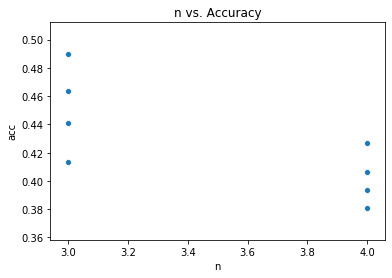

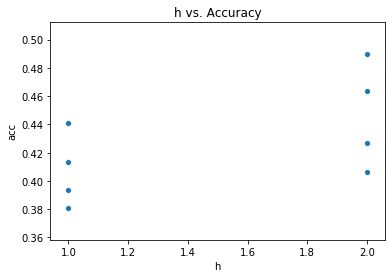

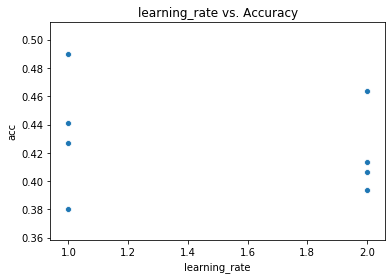

<Figure size 432x288 with 0 Axes>

In [23]:
# Initialize dictionary to contain test accuracy for every hyperparameter combination
dict_combo_acc = dict()

# For each number of layers to test
for n in n_vals:
    
    # For each hidden layer size to test
    for h in h_vals:
        
        # For each learning rate to test
        for learning_rate in learning_rate_vals:
            
            # "Name" of hyperparameter combination (n-h-learning_rate)
            combo = '%s-%s-%s' % (n, h, learning_rate)

            # Set-up K-fold CV
            kf = KFold(n_splits=k)

            # Initialize list to hold testing accuracy for current hyperparameter combination
            all_test_accs = []

            # Build and evaluate model for these hyperparameter combinations k times
            for ii, (train_index, test_index) in enumerate(kf.split(X)):

                # Split data into training and testing data
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Convert testing and training data to tensors
                X_train = torch.from_numpy(X_train).float()
                y_train = torch.from_numpy(y_train)
                X_test = torch.from_numpy(X_test).float()
                y_test = torch.from_numpy(y_test)

                # Build neural network model
                model = build_model(n, h, activation)

                # Loss function
                loss_fn = torch.nn.CrossEntropyLoss()

                # Train model
                train_model(model, X_train, y_train, learning_rate, loss_fn)

                # Evaluate model's performance
                test_acc = evaluate_model(model, X_train, y_train, X_test, y_test, n, h)

                # Append test accuracy to list
                all_test_accs.append(test_acc)

            # Calculate average test accuracy for this hyperparameter combination across k runs
            avg_test_acc = sum(all_test_accs) / len(all_test_accs)
            print('n=%s, h=%s, learning_rate=%s:\nTest accuracy: %.1f%%\n' % (n, h, learning_rate, (avg_test_acc*100)))
            
            # Dictionary of all hyperparameter combinations and its accuracy
            dict_combo_acc[combo] = avg_test_acc

# Print the best hyperparameter comboination and its accuracy
print_best_combo(dict_combo_acc)

# Plot hyperparameters vs. accuracy
plot_hyperparameter_vs_acc(dict_combo_acc)